# Least Squares Policy Iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 10, 6

In [4]:
%load_ext autoreload
%autoreload 2

## Environment

Let's get a really simple environment going -- we'll try to replicate
the paper's results with the [NChain-v0](https://gym.openai.com/envs/NChain-v0/) 
environment.  The environment wrapped up in OpenAI puts a large reward at the
end of the chain, so the optimal strategy is always to go right.  The problem
is made slightly more difficult in that there is a high probability of 
movement error, and you always receive a small reward for going left.

We can solve this pretty easily (1-3 iterations of LSPI with only quadratic 
basis functions).

In [5]:
import gym

In [7]:
length = 10

env = gym.make('NChain-v0')
env.reset()

[2019-03-07 08:36:38,424] Making new env: NChain-v0


0

In [8]:
env.action_space

Discrete(2)

In [20]:
env.observation_space.n

5

In [10]:
obs, reward, done, _ = env.step(0)

## LSTDQ: Least Squares Temporal Difference Q-Learning

In [21]:
from lspi.policy import RandomPolicy, DiscreteActionBasisPolicy
from lspi.basis import IndActionPolyStateBasis

In [23]:
basis = IndActionPolyStateBasis(action_space=gym.spaces.Discrete(2), observation_space=gym.spaces.Discrete(10), order=2)
basis(2, 1)

array([ 0.,  0.,  0.,  1.,  2.,  4.])

In [24]:
basis = IndActionPolyStateBasis(action_space=gym.spaces.Discrete(2), observation_space=gym.make("CartPole-v0").observation_space, order=2)
basis(np.ones(4) * 0.1, 1)

[2019-03-07 08:40:11,345] Making new env: CartPole-v0


array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.1 ,  0.1 ,
        0.1 ,  0.1 ,  0.01,  0.01,  0.01,  0.01])

In [31]:
from lspi.optim import LSTDQ
from lspi.util import generate_sample_data

In [33]:
data = generate_sample_data(1e3, env, RandomPolicy(env))

basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=2)
lstdq = LSTDQ(basis, discount=0.1)
lstdq = lstdq.fit(data, RandomPolicy(env))

In [34]:
from lspi.policy import DiscreteActionBasisPolicy

In [35]:
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=2)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, lstdq.weights_)
dabp(1)

1

In [36]:
from lspi.optim import LSPI

## Running LSPI on OpenAI's NChain-v0 environment

In [37]:
data = generate_sample_data(1e3, env, RandomPolicy(env))
lstdq = LSTDQ(basis, discount=0.7)
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order = 2)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [38]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-5)
lspi.fit(data)

In [39]:
lspi.itr_

2

In [40]:
for state in range(env.observation_space.n):
    print(lspi.policy(state))

1
0
0
0
0


As desired, the learned optimal action for all states is to move to the right.

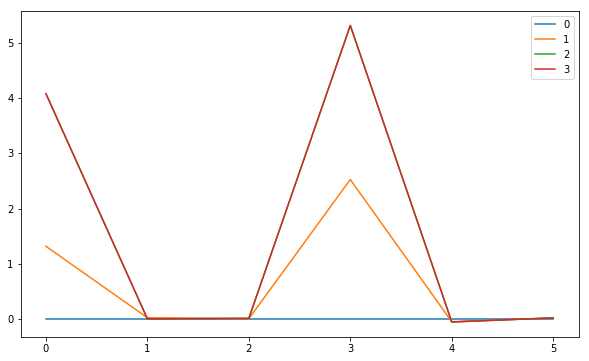

In [102]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

## More complicated chain problems

In the [LSPI paper](https://www2.cs.duke.edu/research/AI/LSPI/) they test on some more complex chains:  

* chains with rewards on either end 
* chains with rewards in the middle

I grabbed [the NChain-v0 code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py)
from OpenAI's github, and modified it 
to support chains of this structure in the file 
[environments.py](./environments.py).

In [42]:
from environments import NChainEnv

length = 10

# first and last states have a reward
reward = np.zeros(length)
reward[2] = 1
reward[7] = 1

env = NChainEnv(reward, slip=0.0, wrap=False)

In [43]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=3)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [44]:
lspi = LSPI(lstdq, dabp, max_iter=100, epsilon=1e-3)
lspi.fit(data)

In [45]:
lspi.itr_

4

In [46]:
policy = [lspi.policy(state) for state in range(env.observation_space.n)]
policy

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0]

In [47]:
expected = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

In [48]:
policies = []
for test in range(20):
    lspi.fit(data)
    policy = [lspi.policy(state) for state in range(env.observation_space.n)]
    policies.append(policy)

In [49]:
np.mean([pol == expected for pol in policies])

1.0

## Cartpole

In [50]:
env = gym.make("CartPole-v0")

[2019-03-07 08:43:07,752] Making new env: CartPole-v0


In [51]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [52]:
env.action_space

Discrete(2)

In [53]:
env.observation_space

Box(4,)

In [54]:
state = env.reset()

In [55]:
state

array([ 0.04320269,  0.01655455, -0.02339418,  0.04743939])

In [56]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=10)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [57]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [58]:
lspi.itr_

49

In [59]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

SyntaxError: invalid syntax (<ipython-input-59-19da4053cdf6>, line 2)

In [52]:
numsteps = []
actions = []

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = lspi.policy(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

In [53]:
np.mean(actions)

0.0

So we're just moving left at every iteration... Which is basically the 
worst policy you could learn haha.  Obviously something is going wrong
either with basis evaluation / weighting or we're not using complex
enough bases.  I'm going to implement RBF bases.

(array([ 155.,    0.,    0.,  415.,    0.,    0.,  404.,    0.,    0.,   26.]),
 array([  8. ,   8.3,   8.6,   8.9,   9.2,   9.5,   9.8,  10.1,  10.4,
         10.7,  11. ]),
 <a list of 10 Patch objects>)

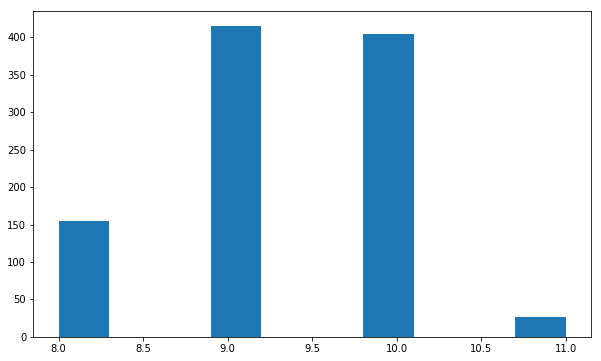

In [43]:
plt.hist(numsteps)

In [44]:
numsteps = []
policy = RandomPolicy(env)

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = policy(state)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

(array([ 447.,  346.,  107.,   58.,   22.,   13.,    4.,    2.,    0.,    1.]),
 array([   8. ,   17.8,   27.6,   37.4,   47.2,   57. ,   66.8,   76.6,
          86.4,   96.2,  106. ]),
 <a list of 10 Patch objects>)

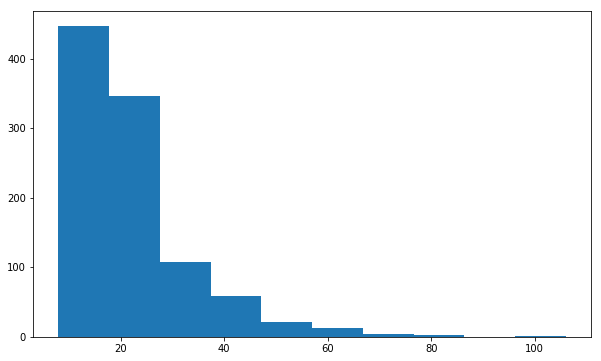

In [45]:
plt.hist(numsteps)